# Part 0: Find and clean appropriate datasets [don't need to rerun]

Your text assignments this block will use two different sources. One is a list of names, as we had back in block 1.
The other will be a bunch of text all from a similar source, likely the collection of books all the same author.
You will find one other person in class to share the same names data, and a different classmate to share the same books data.

You might need to do some preprocessing, which you can do here. We should now have a list of strings in the variable `names` and a big giant string in the variable `books`.

# Part 1: Create x, y data [Rerun this to whole part to reimport data]

In [ ]:
#@title Import libraries and text data
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import csv
from tqdm import tqdm
import sys
import random
csv.field_size_limit(sys.maxsize)
random.seed(234)

## If running on colab / google drive, will need to mount drive
from google.colab import drive
drive.mount('/content/drive')

## If running on colab / google drive, will need to mount drive
with open("/content/drive/MyDrive/Classroom/Machine Learning 2024-25 TUE + FRI Morn2/Fixed_Context_Language/species_names.txt", "r") as f:
    names = [line.strip() for line in f]

# with open("BOOKS FILE HERE", "r") as f:
#     books = f.read()

device = torch.device("cuda")

books = []
allowed_characters = set("█!\"#$%&'()*+,-./0123456789:;<=>?@[\]^_`abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ{|}~ \n\t")
with open("/content/drive/MyDrive/Classroom/Machine Learning 2024-25 TUE + FRI Morn2/Fixed_Context_Language/scp6999.csv", "r") as inp_file:
    for entry in tqdm(csv.DictReader(inp_file), total=6999):
        if "This page doesn't exist." in entry["text"]:
            continue
        end_pos = entry["text"].index("«") if "«" in entry["text"] else -1
        text = entry["text"][0:end_pos]#.lower()
        books.append("".join(char if char in allowed_characters else "#" for char in text ))

random.shuffle(books)

Mounted at /content/drive


100%|██████████| 6999/6999 [00:14<00:00, 499.48it/s]


In [ ]:
#@title Process characters in each dataset
vocab_books = sorted(list(set(''.join(books))))
vocab_names = ['$'] + sorted(list(set(''.join(names)))) # names has the special start / end token

stoi_books = {s:i for i,s in enumerate(vocab_books)}
itos_books = {i:s for s,i in stoi_books.items()}

stoi_names = {s:i for i,s in enumerate(vocab_names)}
itos_names = {i:s for s,i in stoi_names.items()}

print(f"names uses {len(vocab_names)} characters: {''.join(vocab_names)}")
print(f"books uses {len(vocab_books)} characters: {''.join(vocab_books)}")

names uses 30 characters: $ '-abcdefghijklmnopqrstuvwxyz
books uses 97 characters: 
 !"#$%&'()*+,-./0123456789:;<=>?@ABCDEFGHIJKLMNOPQRSTUVWXYZ[\]^_`abcdefghijklmnopqrstuvwxyz{|}~█


In [ ]:
#@title Split into training and validation set

import math
import random

def train_val_split(data, val_fraction = 0.1):
    random.seed(123)
    random.shuffle(data)
    val_count = int(val_fraction * len(data))
    val = data[:val_count]
    train = data[val_count:]
    return train, val

train_names, val_names = train_val_split(names)

## We are splitting books into 1000 even chunks, of which 10% will become validation
## This is lazily just splitting characters evenly, since the gaps will be neglible.
## Feel free to make the split be more intelligently between words or sentences.
num_book_chunks = 1000
chunk_size = math.ceil(len(books) / num_book_chunks)
book_chunks = [books[i:i + chunk_size] for i in range(0, len(books), chunk_size)]
train_books, val_books = train_val_split(book_chunks)
train_books = [i[0] for i in train_books]
val_books = [i[0] for i in val_books]

In [ ]:
#@title Process datasets into x, y to train models
def make_x_y(words, stoi, context_size, start_token = ''):
    """
    Generates input (x) and target (y) data for a language model.

    This function takes a list of words, a string-to-index mapping (stoi),
    and a context size to create context-target pairs for training.
    It pads each word with start tokens and then uses a sliding window
    to generate the context (x) and the target (y) for each position
    in the padded word.

    Args:
        words (list): A list of strings, where each string represents a word or a chunk of text.
        stoi (dict): A dictionary mapping characters to their numerical indices.
        context_size (int): The size of the context window (number of preceding characters
                            to consider for prediction).
        start_token (str, optional): Defaults to '' for books, and should be '$' for names.

    Returns:
        tuple: A tuple containing two PyTorch tensors:
            - x (torch.Tensor): A tensor of shape (num_examples, context_size) representing
                                the input context for each example.
            - y (torch.Tensor): A tensor of shape (num_examples,) representing the target
                                token (to be predicted) for each example.
    """

    xlist = []
    ylist = []

    for i in words:
      newword = i
      length = len(i)-context_size
      if start_token != '':
        newword = context_size*start_token + i + start_token
        length = len(i)+1
      for x in range(length):
        coding = []
        for j in newword[x:x+context_size]:
          coding.append(stoi[j])
        xlist.append(coding)
        ylist.append(stoi[newword[x+context_size]])

    return torch.IntTensor(xlist), torch.IntTensor(ylist)


# the preprocessing to create all the x,y datasets might be a bit slow
# my naive implementation took about 2 minutes to run this cell
# (my books dataset of all HP books is 6.5 million characters,
#  my names dataset of species names is 100k names with a total of
#  1.9 million characters)
# you could pickle / unpickle these variables if your preprocessing is slow
# and you don't want to rerun this cell often

## our x, y datasets will all be dictionaries taking context size as a key
x_train_books, y_train_books, x_val_books, y_val_books = {}, {}, {}, {}
x_train_names, y_train_names, x_val_names, y_val_names = {}, {}, {}, {}
for context_size in [1,2,3,4,6,8,10,12]:
    x_train_books[context_size], y_train_books[context_size] = make_x_y(train_books, stoi_books, context_size)
    x_val_books[context_size], y_val_books[context_size] = make_x_y(val_books, stoi_books, context_size)
    x_train_names[context_size], y_train_names[context_size] = make_x_y(train_names, stoi_names, context_size, start_token = '$')
    x_val_names[context_size], y_val_names[context_size] = make_x_y(val_names, stoi_names, context_size, start_token = '$')


In [ ]:
!pip install dill
import dill
save_path = "/content/drive/MyDrive/Classroom/Machine Learning 2024-25 TUE + FRI Morn2/Fixed_Context_Language/splits.dill"
things = [x_train_books, y_train_books, x_val_books, y_val_books, x_train_names, y_train_names, x_val_names, y_val_names]
with open(save_path, 'wb') as f:
   dill.dump(things,f)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 kB 2.3 MB/s eta 0:00:00


In [ ]:
!pip install dill
import dill
save_path = "/content/drive/MyDrive/Classroom/Machine Learning 2024-25 TUE + FRI Morn2/Fixed_Context_Language/splits.dill"
things = dill.load(open(save_path, "rb"))
for x in range(len(things)):
  for i in things[x]:
    things[x][i] = things[x][i].to(torch.long)
x_train_books, y_train_books, x_val_books, y_val_books, x_train_names, y_train_names, x_val_names, y_val_names = things


Here are some examples of what x and y looked like from my datasets:

In [ ]:
print(train_names[0][:20])
print(' '.join([f'{c}:{stoi_names[c]}' for c in train_names[0]][:20]))
print(x_train_names[3][:7])
print(y_train_names[3][:7])

half naked goby
h:11 a:4 l:15 f:9  :1 n:17 a:4 k:14 e:8 d:7  :1 g:10 o:18 b:5 y:28
tensor([[ 0,  0,  0],
        [ 0,  0, 11],
        [ 0, 11,  4],
        [11,  4, 15],
        [ 4, 15,  9],
        [15,  9,  1],
        [ 9,  1, 17]])
tensor([11,  4, 15,  9,  1, 17,  4])


In [ ]:
print(train_books[0][:20])
print(' '.join([f'{c}:{stoi_books[c]}' for c in train_books[0]][:20]))
print(x_train_books[3][:7])
print(y_train_books[3][:7])

"SCP-3454: The Land 
":3 S:52 C:36 P:49 -:14 3:20 4:21 5:22 4:21 ::27  :1 T:53 h:73 e:70  :1 L:45 a:66 n:79 d:69  :1
tensor([[ 3, 52, 36],
        [52, 36, 49],
        [36, 49, 14],
        [49, 14, 20],
        [14, 20, 21],
        [20, 21, 22],
        [21, 22, 21]])
tensor([49, 14, 20, 21, 22, 21, 27])


In [ ]:
#@title generate_text function
def generate_text(sampling_function, context_size, stoi, start = "", itos = None, max_length = 100):
    """
    Generate text using a given sampling function and context size.

    Args:
        sampling_function (callable): A function that takes a context (list of token IDs)
                                     and returns the next token ID.
        context_size (int): Size of the context window used by the model.
        stoi (dict): String-to-index mapping dictionary to convert characters to token IDs.
        start (str, optional): Initial text to start generation with. Defaults to "".
        itos (dict, optional): Index-to-string mapping dictionary. If None, will be created
                              from stoi. Defaults to None.
        max_length (int, optional): Maximum length of the generated text. Defaults to 100.

    Returns:
        str: The generated text, including the start string if provided.

    Notes:
        - If start is empty, assumes a special start/end token with index 0.
        - Generation stops when max_length is reached or an end token (0) is generated
          (only when start is empty, indicating generation with start/end tokens).
    """
    if itos is None:
        itos = {i:s for s,i in stoi.items()}
    has_end_token = (len(start) == 0) # if there is no starting context, we assume there is a start / end token with index 0
    # initialize context to pad with 0s for start tokens
    context = [0] * (context_size - len(start))
    context += [stoi[c] for c in start][-context_size:]
    output = start
    for _ in range(max_length):
        next_id = sampling_function(context)
        if has_end_token and next_id == 0:
            break
        context = context[1:] + [next_id]
        output += itos[next_id]
    return output

# Part 2: Train NGramModel as a baseline [don't need to rerun]

We already did this in Block 1. Here is a prewritten version of an n-gram model class which will act on datasets x, y of the form we processed above. If you got Part 1 working correctly, you should be able to run all this code as written and see some generated text from your datasets.

In [ ]:
#@title NGramModel class
class NGramModel:
    def __init__(self, x_train, y_train, reg=0.001):
        """
        Initialize a simple n-gram model using NumPy arrays

        Args:
        - x_train: PyTorch tensor of input sequences (num_sequences, context_size)
        - y_train: PyTorch tensor of target tokens (num_sequences,)
        - reg: Initial amount added to all counts for regularization
        """
        # Convert PyTorch tensors to NumPy arrays if needed
        if isinstance(x_train, torch.Tensor):
            x_train = x_train.numpy()
        if isinstance(y_train, torch.Tensor):
            y_train = y_train.numpy()

        # Verify input arrays
        assert x_train.ndim == 2 and y_train.ndim == 1
        assert x_train.shape[0] == y_train.shape[0]

        # Infer model parameters
        self.vocab_size = max(np.max(x_train), np.max(y_train)) + 1
        self.context_size = x_train.shape[1]

        # Create multi-dimensional array for counts, initialized as reg
        count_shape = [self.vocab_size] * (self.context_size + 1)
        self.counts = np.ones(count_shape, dtype=np.float32) * reg

        # Increment counts using NumPy's advanced indexing
        indices = tuple(np.column_stack([x_train, y_train.reshape(-1, 1)]).T)
        # This adds 1.0 to each n-gram occurrence in a single vectorized operation
        np.add.at(self.counts, indices, 1.0)

        # Compute probabilities
        # Sum over the last dimension (target tokens) to get marginal counts
        marginal_counts = np.sum(self.counts, axis=-1, keepdims=True)
        # Divide to get conditional probabilities P(target | context)
        self.probs = self.counts / marginal_counts

    def test(self, x_val, y_val):
        """
        Compute average negative log-likelihood on validation set
        """
        # Convert to NumPy if needed
        if isinstance(x_val, torch.Tensor):
            x_val = x_val.numpy()
        if isinstance(y_val, torch.Tensor):
            y_val = y_val.numpy()

        x_y_combined = np.column_stack([x_val, y_val.reshape(-1, 1)])
        indices = tuple(x_y_combined.T)

        # Get probabilities using NumPy advanced indexing
        probs = self.probs[tuple(indices)]

        # Calculate negative log-likelihood and return average
        return -np.mean(np.log(probs))

    def sample(self, context):
        return np.random.choice(self.vocab_size, p = self.probs[tuple(context)])




In [ ]:
#@title see some examples from names data
context_size = 4 # try changing context_size, but be careful
                 # if it's too big it will use too much memory and crash
model = NGramModel(x_train_names[context_size], y_train_names[context_size])
for _ in range(5):
    print(generate_text(model.sample, context_size, stoi_names))

elon kimberlined catfish
schmer's wolf-fish
few sunfish
asukur forestfly
caatingfin broadstriped eel


In [ ]:
#@title see some examples from books data
context_size = 3
start_text = "SCP"
model = NGramModel(x_train_books[context_size], y_train_books[context_size])
for _ in range(5):
    print(generate_text(model.sample, context_size, stoi_books, start_text))
    print()

SCP-1140-S may that wasn't heard on ovestical Proceduring, wers day such? As inten vand I has and to th

SCP-6275 SCP-366503:13 (in 10#MHz fold by NAME: Plear of ture degring faced 08/2011, ash-Nanagh!" 
 SCP

SCP-5060: Yeah, each respeciety of they depearn we melem #: SCP-1695-B and ██████, SCP-312 hable neith 

SCP-422 
 [A-1: [Sight sprehen reate? When seemeternatechnology have the SCP-5103 is a woulso been memb

SCP-1411-1. Test damned. When formation we've serve (a sensisting lister tumber backer-Frienceas rea-3:



In [ ]:
#@title evaluate n-gram models across a range of hyperparameters
import time
def test_ngram_model(x_train_dict, y_train_dict, x_val_dict, y_val_dict,
                              context_sizes, reg_values, dataset_name,
                              start, stoi, itos=None, num_samples=3, gen_length=100):

    print(f"\n{'='*50}")
    print(f"Evaluating NGramModel on {dataset_name} dataset")
    print(f"{'='*50}")

    results = []

    for context_size in context_sizes:
        x_train = x_train_dict[context_size]
        y_train = y_train_dict[context_size]
        x_val = x_val_dict[context_size]
        y_val = y_val_dict[context_size]

        print(f"\ncontext size: {context_size}")
        print(f"Training set: {len(x_train)} examples")
        print(f"Validation set: {len(x_val)} examples")

        for reg in reg_values:
            start_time = time.time()
            model = NGramModel(x_train, y_train, reg)
            train_loss = model.test(x_train, y_train)
            val_loss = model.test(x_val, y_val)
            train_time = time.time() - start_time
            param_count = np.prod(model.probs.shape)

            results.append({
                'dataset_name': dataset_name,
                'context_size': context_size,
                'reg': reg,
                'train_loss': train_loss,
                'val_loss': val_loss,
                'train_time': train_time,
                'param_count': param_count
            })

            print(f"\nReg={reg}, Training time: {train_time:.2f}s")
            print(f"  Train loss: {train_loss:.4f}")
            print(f"  Val loss:   {val_loss:.4f}")

            # Generate samples
            print("\nGenerated samples:")
            for i in range(num_samples):
                print(generate_text(model.sample, context_size, stoi, start, max_length = gen_length))

    return results

def print_results(results):
    # Print summary table
    print(f"Summary of Results for {results[0]['dataset_name']} data:")
    print(f"{'context':<6} {'Reg':<6} {'Train Loss':<12} {'Val Loss':<12} {'Time (s)':<10}{'Param Count'}")
    print(f"{'-'*75}")
    for r in results:
        print(f"{r['context_size']:<6} {r['reg']:<6.3f} {r['train_loss']:<12.4f} {r['val_loss']:<12.4f} {r['train_time']:<10.2f}{r['param_count']}")

# Run evaluations for both datasets
print("Starting evaluation...")

# # Names dataset with context sizes 1-4
names_results = test_ngram_model(
    x_train_names, y_train_names,
    x_val_names, y_val_names,
    context_sizes=[1, 2, 3, 4],
    reg_values=[0.001, 0.01, 0.1],
    dataset_name = "names",
    start = "",
    stoi = stoi_names
)

# Books dataset with context sizes 1-3
start_book_sample = "Harry " # starting string for samples
books_results = test_ngram_model(
    x_train_books, y_train_books,
    x_val_books, y_val_books,
    context_sizes=[1, 2, 3],
    reg_values=[0.001, 0.01, 0.1],
    dataset_name = "books",
    start = start_book_sample,
    stoi = stoi_books,
    gen_length=100
)

print("Evaluation complete!")

Starting evaluation...

Evaluating NGramModel on names dataset

context size: 1
Training set: 1782872 examples
Validation set: 198343 examples

Reg=0.001, Training time: 0.48s
  Train loss: 2.5808
  Val loss:   2.5834

Generated samples:
bakfickewtewo
ronth
smy us by

Reg=0.01, Training time: 0.46s
  Train loss: 2.5808
  Val loss:   2.5834

Generated samples:
pitenint
ran chowread snalaleshedomilam
rogs

Reg=0.1, Training time: 0.46s
  Train loss: 2.5808
  Val loss:   2.5833

Generated samples:
shipal rsindina diamascurinoojeleserperatrattlel
nted
d len st-jonacrkes merrt

context size: 2
Training set: 1782872 examples
Validation set: 198343 examples

Reg=0.001, Training time: 0.55s
  Train loss: 2.0962
  Val loss:   2.1021

Generated samples:
madfish
rundestainuoillopsmiled ragudassuper broys
bard

Reg=0.01, Training time: 0.45s
  Train loss: 2.0962
  Val loss:   2.1005

Generated samples:
pytheromeadee-stair hartlet ge
que spine
ne eseank

Reg=0.1, Training time: 0.30s
  Train loss: 

In [ ]:
#@title names data results
print_results(names_results)

Summary of Results for names data:
context Reg    Train Loss   Val Loss     Time (s)  Param Count
---------------------------------------------------------------------------
1      0.001  2.5808       2.5834       0.48      900
1      0.010  2.5808       2.5834       0.46      900
1      0.100  2.5808       2.5833       0.46      900
2      0.001  2.0962       2.1021       0.55      27000
2      0.010  2.0962       2.1005       0.45      27000
2      0.100  2.0968       2.0994       0.30      27000
3      0.001  1.5635       1.6316       0.43      810000
3      0.010  1.5647       1.6149       0.44      810000
3      0.100  1.5740       1.6068       0.43      810000
4      0.001  1.1421       1.3576       0.75      24300000
4      0.010  1.1489       1.3102       1.01      24300000
4      0.100  1.1976       1.3034       0.76      24300000


In [ ]:
#@title books data results
print_results(books_results)

Summary of Results for books data:
context Reg    Train Loss   Val Loss     Time (s)  Param Count
---------------------------------------------------------------------------
1      0.001  2.5253       2.5342       1.21      9409
1      0.010  2.5253       2.5338       1.23      9409
1      0.100  2.5253       2.5334       1.19      9409
2      0.001  2.0088       2.0880       1.63      912673
2      0.010  2.0092       2.0775       2.50      912673
2      0.100  2.0124       2.0698       2.41      912673
3      0.001  1.5566       1.7988       4.04      88529281
3      0.010  1.5604       1.7555       4.02      88529281
3      0.100  1.5835       1.7334       3.12      88529281


Now we have some baseline values to try to compare against for our other models. The most notable numbers here are how much validation loss we can get based on parameter count.

# Part 3: Create PyTorch model and train function [rerun this cell to create model class and train function]

The key new PyTorch layer we will be using is `nn.embedding`:

https://pytorch.org/docs/stable/generated/torch.nn.Embedding.html

In [ ]:
#@title base class FixedContextLanguageModel
class FixedContextLanguageModel(nn.Module):
    """
    Base class for language models that predict the next character based on a context window.
    """
    def __init__(self):
        super().__init__()

    def forward(self, x):
        """
        Forward pass to compute scores for next token prediction.

        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, context_size)

        Returns:
            torch.Tensor: Scores for each token in vocabulary, shape (batch_size, vocab_size)
        """
        raise NotImplementedError("Subclasses must implement forward method")

    def count_params(self):
        """Count the number of trainable parameters in the model."""
        return sum(p.numel() for p in self.parameters() if p.requires_grad)

    def sample(self, context):
        """
        Sample the next token given a context of token IDs.

        Args:
            context (list): A list of token IDs representing the context

        Returns:
            int: The sampled next token ID

        Notes:
            - The context should be a list of token IDs with length matching the model's expected context size
            - This method converts the list to a tensor, performs a forward pass, applies softmax to get
              probabilities, then samples from the resulting distribution
        """
        # Convert context list to tensor with appropriate shape (1, context_size)
        x = torch.tensor([context], dtype=torch.long, device=device)

        # Get scores from model (forward pass)
        with torch.no_grad():
            scores = self(x)

        # Convert scores to probabilities
        probs = torch.softmax(scores, dim=1).squeeze(0).numpy(force=True)

        # Sample from the probability distribution
        next_token = np.random.choice(len(probs), p=probs)

        return next_token

class BigramLanguageModel(FixedContextLanguageModel):
    """
    Just using the nn.Embedding layer will give something equivalent to bigrams.
    """
    def __init__(self, vocab_size):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, vocab_size)

    def forward(self, x):
        # x shape: (batch_size, context_size = 1)
        embedded = self.embedding(x) # (batch_size, context_size = 1, vocab_size)
        return embedded.squeeze(1)  # squeeze out dimension 1 to get (batch_size, vocab_size)

In [ ]:
context_size = 1
model = BigramLanguageModel(len(stoi_names))
input = x_train_names[1][:3]
print(input)
print(model(input).shape)

for _ in range(3):
    print(generate_text(model.sample, context_size, stoi_names))

tensor([[ 0],
        [11],
        [ 4]])
torch.Size([3, 30])
a'ylil'nmmmfmempk
tathqkjhdhgew'yghqycipwtwqrju-jbsrzcsdrdzokfmhtcuny-hdhteeiemd'zborg'zddg'scli
mbxwnl f wfisyfmm-uuxwtrnpy-ip-ygkjhq-isxz


In [ ]:
#@title The big train function
def train(model, x_train, y_train, x_val, y_val, stoi, gpu=False, start="",
          num_epochs=5, batch_size=500, lr=0.001, report=1000, epochsize = 1000000, save_path = "/content/drive/MyDrive/Classroom/Machine Learning 2024-25 TUE + FRI Morn2/Fixed_Context_Language/language_model.dill"):

    if gpu:
      x_train = x_train.to(device)
      y_train = y_train.to(device)
      x_val = x_val.to(device)
      y_val = y_val.to(device)

    context_size = x_train.shape[1]

    # Set up data loader for batched training
    train_dataset = torch.utils.data.TensorDataset(x_train, y_train)
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    # Set up loss function and optimizer
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    t = 0

    def snapshot(loss):
        print("Train Loss: "+str(loss))
        for x in range(0,3):
          print(generate_text(model.sample, context_size, stoi, start = start))
        print()


    losslist = []
    vallosslist = []

    bestval = None

    for epoch in range(num_epochs):
        print("Epoch "+str(epoch))
        print()
        t2 = 0
        totalloss = 0
        # basic logic for training over an epoch
        model.train()
        for batch_x, batch_y in train_loader:
            t2 += 1
            optimizer.zero_grad()
            scores = model(batch_x)
            loss = loss_fn(scores, batch_y)
            totalloss += loss.item()
            loss.backward()
            optimizer.step()

            # an epoch will take a while, so we should periodically
            # get some information about how the model is doing,
            # calling our snapshot function we created above
            # (you could decide to trigger snapshot a set number of batches,
            # or a set number of seconds)
            t += 1
            if t % report == 0:
              snapshot(loss.item())
            if t2 >= epochsize:
              break
        totalloss /= t2
        losslist.append(totalloss)

        # Get the entire validation loss at the end of each epoch
        model.eval()
        with torch.no_grad():
            val_scores = model(x_val)
            val_loss = loss_fn(val_scores, y_val).item()
        model.train()

        vallosslist.append(val_loss)

        if bestval is None or bestval > val_loss:
          torch.save(model, save_path, pickle_module=dill)
          bestval = val_loss

        print("Epoch Train Loss: "+str(totalloss)+", Val Loss: "+str(val_loss))
        print()




        # TODO: print / store this information
        # TODO: save the model if the validation loss is the best so far
        # https://pytorch.org/docs/stable/generated/torch.save.html#torch.save
        # https://pytorch.org/docs/stable/generated/torch.load.html#torch.load
        # TODO: decide how to record training loss information

    import matplotlib
    plt.plot(losslist)
    plt.plot(vallosslist)
    plt.show()

# Part 4: Test Train Function on BigramLanguageModel

Epoch 0

Train Loss: 3.1549365520477295
cytybttkjyi rure tqxu'-ryeazhay-'shwfwrid
w'm fez-himdsil
leafhech

Train Loss: 2.862358808517456
-'ate
pobupe
outerockeaneranlbizyfi'oyqudijjengongqungcuk i'rfriernyrig

Train Loss: 2.7089009284973145
ronlcad
gk ucpc-flizis
sj owl

Epoch Train Loss: 2.9834769294292687, Val Loss: 2.643303394317627

Epoch 1

Train Loss: 2.585418939590454
blecor hin snarsch
sa
fialaydarekbal

Train Loss: 2.6060256958007812
m
ppinemeant sh
ys

Train Loss: 2.6708009243011475
by
bin'se-ndins
rostitt reontaethiat

Train Loss: 2.5421433448791504
bt
bbag by-ch
mmblyghed liseado

Epoch Train Loss: 2.603718860591989, Val Loss: 2.590665102005005

Epoch 2

Train Loss: 2.5900394916534424
co
ngzfia
jack chinkiporeedbrzac w shblanarilleketipotungo

Train Loss: 2.597304582595825
raf aush
tilyee tf bust
begha ld pacallorbratyama glid lfis

Train Loss: 2.585843801498413
a bewilamow
r
rblh

Epoch Train Loss: 2.5845999055810007, Val Loss: 2.5849769115448

Epoch 3

Train Loss: 2.6058

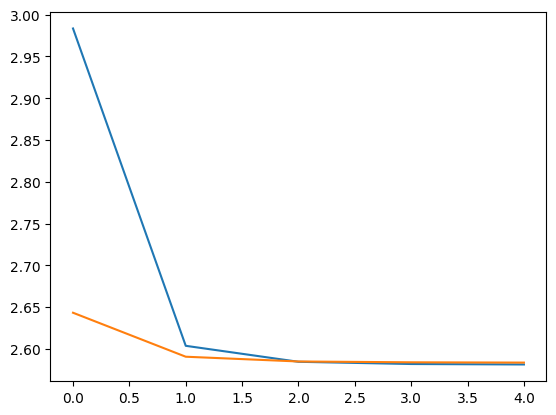

In [ ]:
bigrammodel = BigramLanguageModel(len(vocab_names)).to(device)

train(bigrammodel, x_train_names[1], y_train_names[1], x_val_names[1], y_val_names[1], stoi_names, gpu=True, save_path="/content/drive/MyDrive/Classroom/Machine Learning 2024-25 TUE + FRI Morn2/Fixed_Context_Language/bigram_model_names.dill")

## Question: From looking at the results in Part 2, what do you expect the training / validation loss to converge to when you run BigramLanguageModel on your names and books datasets? Why?

It should approach the normal bigram, because the best way to minimize loss is to match the training probability distribution.

# Part 5: Create and Train LinearLanguageModel

In [ ]:
class LinearLanguageModel(FixedContextLanguageModel):
    """
    A linear language model that predicts the next character based on a context window.

    Args:
        context_size (int): The size of the context window.
        vocab_size (int): The size of the vocabulary.
        embedding_dim (int, optional): Dimension of character embeddings. Defaults to 16.
    """
    def __init__(self, context_size, vocab_size, embedding_dim=16):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.linear = nn.Linear(embedding_dim*context_size, vocab_size)
        ## also need to create an nn.Linear object
        ## https://pytorch.org/docs/stable/generated/torch.nn.Linear.html

    def forward(self, x):
        # x shape: (batch_size, context_size)
        embedded = self.embedding(x)  # (batch_size, context_size, embedding_dim)
        scores =  self.linear(nn.Flatten()(embedded))
        return scores



Epoch 0

Train Loss: 2.253105401992798
ruuttom hernfish
sposper seerel
singan worlse

Train Loss: 2.3683927059173584
cougflyc's
woreo nacee
morser crniapeara

Train Loss: 2.229182481765747
guitsw bilead braher cimb
arishena tamulio
nowtepea fas

Epoch Train Loss: 2.359466016927731, Val Loss: 2.2676517963409424

Epoch 1

Train Loss: 2.18144154548645
fortad buck-thoape dand errirn
contiow-fish
bbacked whares racka

Train Loss: 2.3169894218444824
shard etack scalof share
kompoot scaten
hopstard cateflib

Train Loss: 2.336575508117676
pled-byich
mackebleat lopaea
dargora gissa

Train Loss: 2.1591877937316895
tordaid's guipin piambea
bolsherud
miseay ored blow-yfashowl

Epoch Train Loss: 2.257060514095454, Val Loss: 2.2501256465911865

Epoch 2

Train Loss: 2.3053536415100098
kwrrmanew brickhil
shoteld mckkite
amick'n squevfost

Train Loss: 2.263664722442627
hovasked gringfine
nowtand sttirg sumal caskin livere surewos
tongtorf backl

Train Loss: 2.1456832885742188
checkoty anib
lingrodr's s

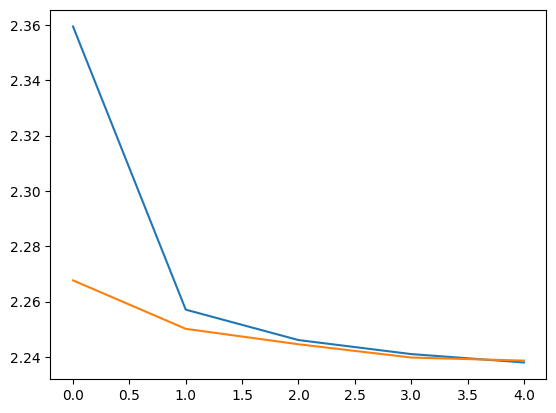

In [ ]:
linearlanguagemodel = LinearLanguageModel(10, len(vocab_names)).to(device)
train(linearlanguagemodel, x_train_names[10], y_train_names[10], x_val_names[10], y_val_names[10], stoi_names, gpu=True, save_path="/content/drive/MyDrive/Classroom/Machine Learning 2024-25 TUE + FRI Morn2/Fixed_Context_Language/tengram_linear_model_names.dill")

# Part 6: Create and Train Nonlinear Models


First thing to try: simple 2 layer neural net.
https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html is the only other layer needed

Then try to use various ideas / layers from the last block to see how much better you can use.
* https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm1d.html will probably help for deeper networks
* https://pytorch.org/docs/stable/generated/torch.nn.Conv1d.html 1 dimensional convolutions would be a really interesting thing to try
* https://pytorch.org/docs/stable/generated/torch.nn.Dropout.html you could consider adding dropout, but I would only do so if you start seeing evidence of overfitting. Given how few epochs we are training over, you probably won't be overfitting too much at first


In [ ]:
class NonLinearLanguageModel(FixedContextLanguageModel):
    """
    A linear language model that predicts the next character based on a context window.

    Args:
        context_size (int): The size of the context window.
        vocab_size (int): The size of the vocabulary.
        embedding_dim (int, optional): Dimension of character embeddings. Defaults to 16.
    """
    def __init__(self, context_size, vocab_size, embedding_dim=16):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.seq = nn.Sequential(
            nn.Flatten(),
            nn.Linear(embedding_dim*context_size, 200),
            nn.ReLU(),
            nn.LayerNorm(200),
            nn.Linear(200, 200),
            nn.ReLU(),
            nn.LayerNorm(200),
            nn.Linear(200, 200),
            nn.ReLU(),
            nn.Dropout(),
            nn.LayerNorm(200),
            nn.Linear(200, 200),
            nn.ReLU(),
            nn.LayerNorm(200),
            nn.Linear(200, vocab_size)
        )
        ## also need to create an nn.Linear object
        ## https://pytorch.org/docs/stable/generated/torch.nn.Linear.html

    def forward(self, x):
        # x shape: (batch_size, context_size)
        embedded = self.embedding(x)  # (batch_size, context_size, embedding_dim)
        scores =  self.seq(embedded)
        return scores

# 2-layer: names val loss - 1.731, books val loss - 1.807
# 3-layer - 1.565 names val loss

# Using Conv gave good losses but generated gibberish
# With_conv - 1.551 names val loss
# With_VGG - 1.500 names val loss
# Double VGG - 1.454 names val loss
# More Epochs - 1.401 names, 1.581 books

# 4 layers - 1.503 val loss
# 4 layers with 1 norm - 1.471 val loss
# 4 layers with all norms: 1.460 val loss
# 5 layers with all norms: 1.420 for names, 1.567 for books
# 5 layers with double the width + dropout: 1.388 for names, 1.536 for books

Epoch 0

Train Loss: 1.9686087369918823
mortaccalageba
grua hocket
moorion sver

Train Loss: 1.8196474313735962
herred bat
raisuck-boe
chidau's swie sharpiopfishfi'letail

Train Loss: 1.5781382322311401
peatlest yempeako
giant ognicase
short-tailed bittlehobry greenfish

Epoch Train Loss: 1.8608347080560192, Val Loss: 1.5485302209854126

Epoch 1

Train Loss: 1.6574231386184692
narroan pingrer
greenflole eedler's kanogerlip lonefish
froyical moth goby

Train Loss: 1.5555435419082642
spid spotted bat
southern guater
commonus gardenfish

Train Loss: 1.5742546319961548
hooded rufous-white red-lassen neffees
parnish werpottot
brisa stem's trip

Train Loss: 1.5314738750457764
spiny uaplony
fhavy esanto
cape mangux

Epoch Train Loss: 1.5834149925881267, Val Loss: 1.4730544090270996

Epoch 2

Train Loss: 1.6281068325042725
ibandy moonshopper
spur warbler
siver's perific voper

Train Loss: 1.4285869598388672
banded catfish
commalank buck gry's coral
dark-winged voreast serid

Train Loss: 1.5838

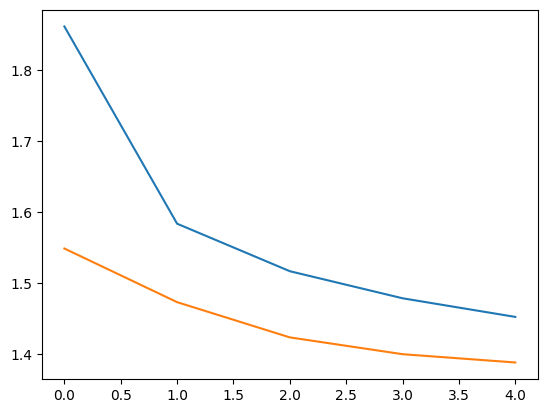

In [ ]:
nonlinearlanguagemodel_names = NonLinearLanguageModel(10, len(vocab_names)).to(device)
train(nonlinearlanguagemodel_names, x_train_names[10], y_train_names[10], x_val_names[10], y_val_names[10], stoi_names, gpu=True, save_path="/content/drive/MyDrive/Classroom/Machine Learning 2024-25 TUE + FRI Morn2/Fixed_Context_Language/linear5_normed2xdropout.dill")

Epoch 0

Train Loss: 2.079116106033325
SCP-5405# Anstance unper for nos tous to thinfergalely when ix! preval the yaving the pauls you hink, w
SCP-2289: 
 D-84530: SC A1-4-27 boy, bindearts with rim-n wecclectuily hrhoughay paill is, itteabily su
SCPe.25716 CO[IARI  secarcrecta frem SCP-2064 a stent be, blase ippprespored lackpend ever udcards infr

Train Loss: 1.9469534158706665
SCP]6375 That. 
: Deneratic 
 The just of exadlly, no hing mimm. What "oiping fandstatorycrimitery porc
SCP-2071 Ciferatifee on SCP-35-2 and Stuc.. ded g ouks that SCP-2933 ieviect what beichs sonttien: Snew
SCP-4816 or wCF, docned de didn't dempipporness deit w-14 wodd ebde thunds, spevee nee. 
 The aye 
ale 

Train Loss: 1.786399483680725
SCP-2174 event is a composed what Sto would to to to be the miyther wean. Ore actumaly becurely-lily'e 
SCP-1350's supped or Fommroy tingly, stidlast know the syee the prajer cupperenting thear tue helonged 
SCPaNLAD Gildicates: You█
DHO AL Han heirveil aftely is moutowes b

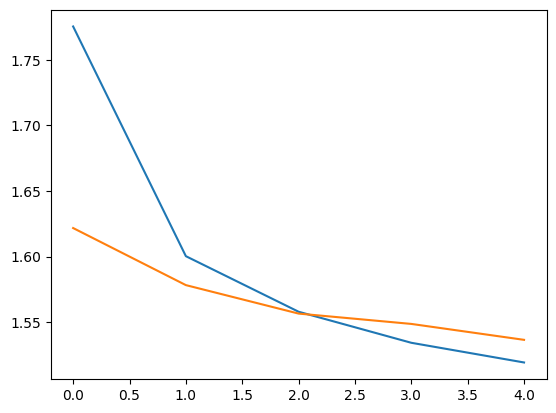

In [ ]:
nonlinearlanguagemodel_books = NonLinearLanguageModel(10, len(vocab_books)).to(device)
train(nonlinearlanguagemodel_books, x_train_books[10], y_train_books[10], x_val_books[10], y_val_books[10], stoi_books, gpu=True, start="SCP", save_path="/content/drive/MyDrive/Classroom/Machine Learning 2024-25 TUE + FRI Morn2/Fixed_Context_Language/linear5_normed2xdropout_books.dill")

# Part 7: Analyze the best model you trained for names / books

## Report on what your training process was like.
What worked best? What were your final validation losses / parameter counts and how does that compare to our n-gram baseline and simpler linear models?

I was able to get under the val loss for books for the n-gram but not the names using a VGG architecture with batchnorm. I got a loss of 1.388 on names and 1.536 on books. I used a 5-layer network with layernorms and one dropout layer; I had tried convolutional layers earlier but they made the generations devolve into gibberish. The books dataset seems to overfit a lot more, but I've limited it a lot with the dropout.

## Show more final samples from each of your models

Save a text file with 1000 generated samples from names (one per line), which we might use later to start playing a game of "is this an actual ____ or is it AI generated?"

In [ ]:
!pip install dill
import dill
save_path = "/content/drive/MyDrive/Classroom/Machine Learning 2024-25 TUE + FRI Morn2/Fixed_Context_Language/linear5_normed2xdropout.dill"
model = torch.load(save_path, pickle_module=dill)

file_path = "/content/drive/MyDrive/Classroom/Machine Learning 2024-25 TUE + FRI Morn2/Fixed_Context_Language/generated_names.txt"
generated = []
for i in range(1000):
  generated.append(generate_text(model.sample, 10, stoi_names)+"\n")
f = open(file_path, "w")
f.writelines(generated)
f.close()

## Take a look at embedding matrix

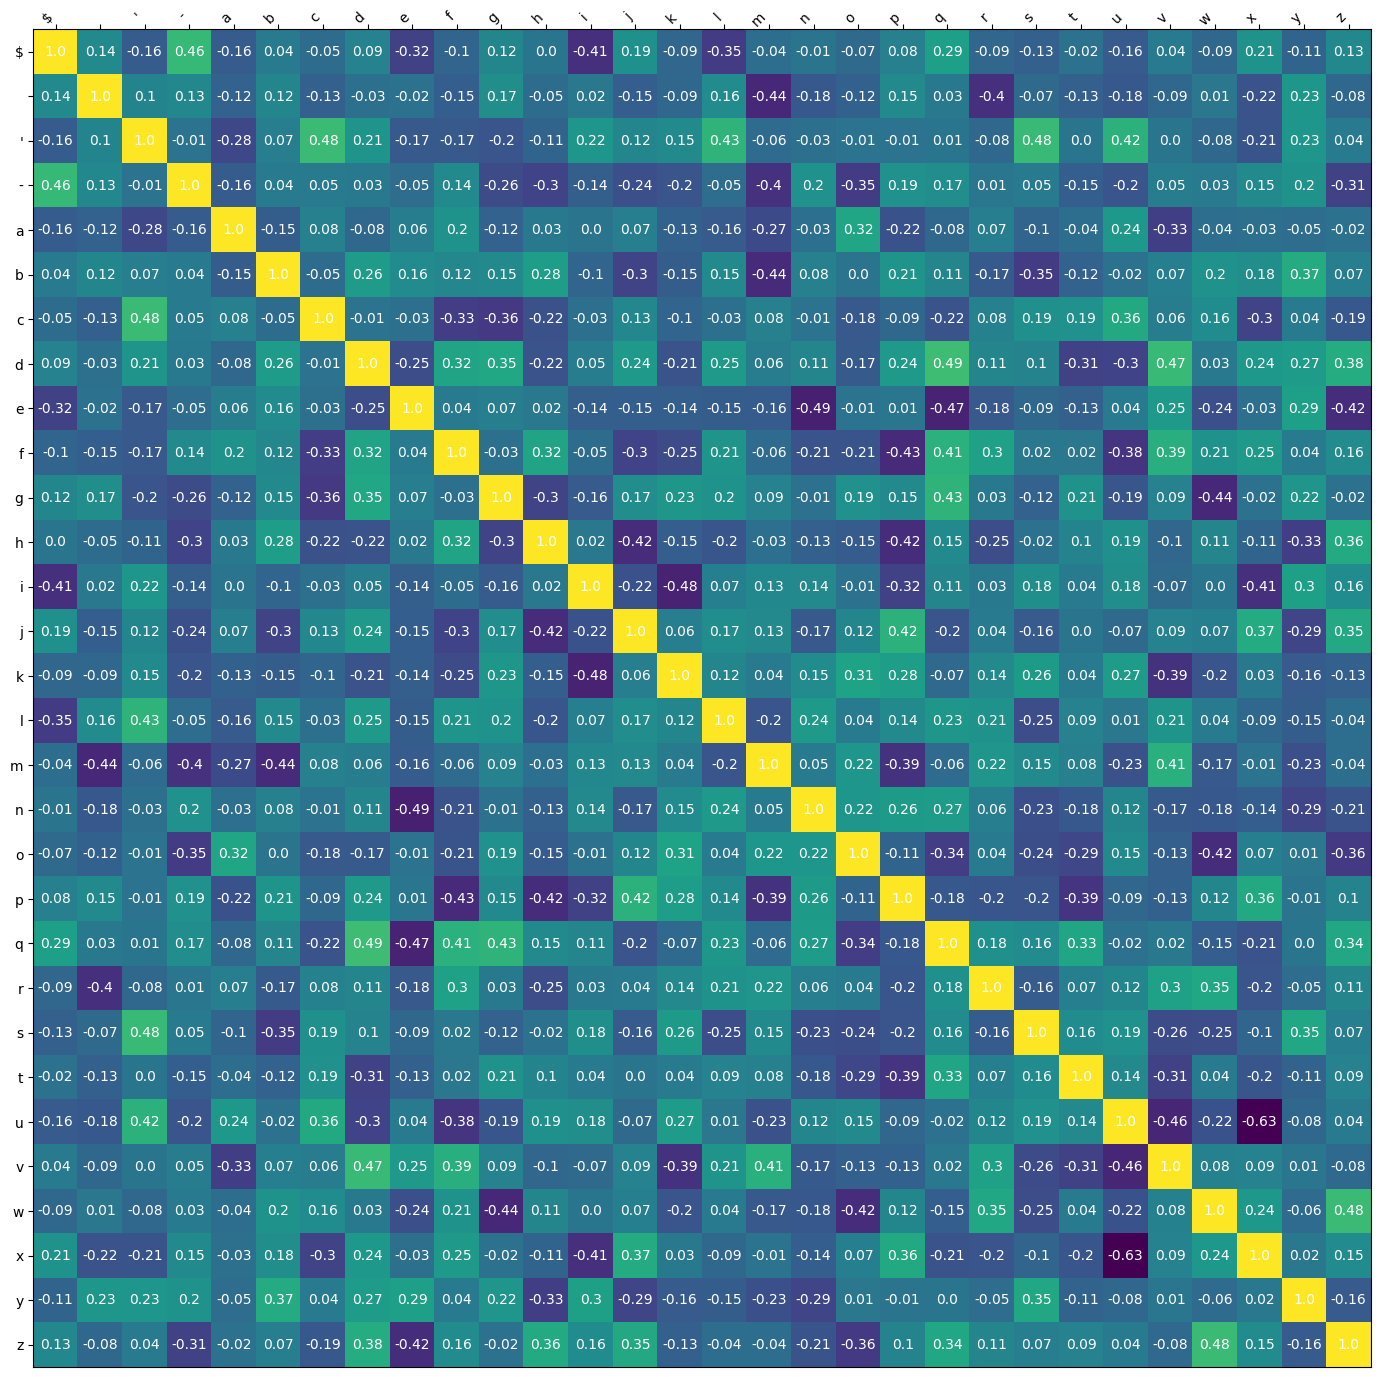

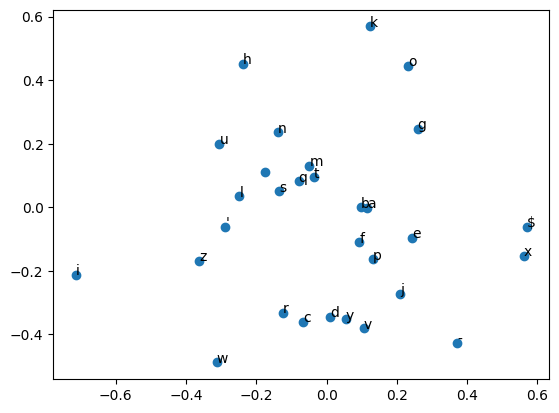

In [ ]:
!pip install dill
import dill
save_path = "/content/drive/MyDrive/Classroom/Machine Learning 2024-25 TUE + FRI Morn2/Fixed_Context_Language/linear5_normed.dill"
model = torch.load(save_path, pickle_module=dill)

embedding_weights = model.embedding.weight.detach().cpu().numpy()


norms = np.sqrt(np.sum(embedding_weights**2, axis=1, keepdims=True))

embedding_weights /= norms

dots = embedding_weights @ embedding_weights.T


diffs = dots

fig, ax = plt.subplots()
im = ax.imshow(diffs)

# Show all ticks and label them with the respective list entries
ax.set_xticks(range(len(vocab_names)), labels=vocab_names,
              rotation=45, ha="right", rotation_mode="anchor")
ax.set_yticks(range(len(vocab_names)), labels=vocab_names)

# Loop over data dimensions and create text annotations.
for i in range(len(vocab_names)):
    for j in range(len(vocab_names)):
        text = ax.text(j, i, round(diffs[i, j]*100)/100,
                       ha="center", va="center", color="w")

ax.tick_params(top=True, labeltop=True, bottom=False, labelbottom=False)
fig.tight_layout()
fig.set_size_inches(15, 15)
plt.show()

x = embedding_weights[:,0]
y = embedding_weights[:,1]
l = vocab_names

# First two coordinates of the vectors - projected to 2d space
plt.scatter(x, y)
for i in range(len(l)):
  plt.text(x[i], y[i], l[i])


# Sources Cited / Reflection

I feel like I might want to change the books dataset a bit - a lot of the articles have a "scientific" portion and an "interview" portion that are in very different styles so I might want to only choose the former. Also, convolutions are terrible - they make the loss go down but generates gibberish.